Step: 0, Error: 0.169468, Position: [0.073  0.0895 0.1195]
Step: 1, Error: 0.170175, Position: [0.07254196 0.08894229 0.11949905]
Step: 2, Error: 0.170622, Position: [0.0722538  0.08858903 0.11949892]
Step: 3, Error: 0.171061, Position: [0.0719699  0.08824115 0.11949881]
Step: 4, Error: 0.171500, Position: [0.0716866  0.08789404 0.11949873]
Step: 5, Error: 0.171936, Position: [0.07140517 0.08754928 0.11949867]
Step: 6, Error: 0.172371, Position: [0.0711244  0.08720532 0.11949862]
Step: 7, Error: 0.172804, Position: [0.07084496 0.086863   0.11949858]
Step: 8, Error: 0.173246, Position: [0.07055948 0.08651331 0.11949855]
Step: 9, Error: 0.173681, Position: [0.07027864 0.08616932 0.11949852]
Step: 10, Error: 0.174110, Position: [0.07000215 0.08583064 0.11949851]
Step: 11, Error: 0.174537, Position: [0.0697266  0.08549312 0.11949849]
Step: 12, Error: 0.174962, Position: [0.06945238 0.08515723 0.11949848]
Step: 13, Error: 0.175386, Position: [0.069179   0.08482237 0.11949847]
Step: 14, Erro

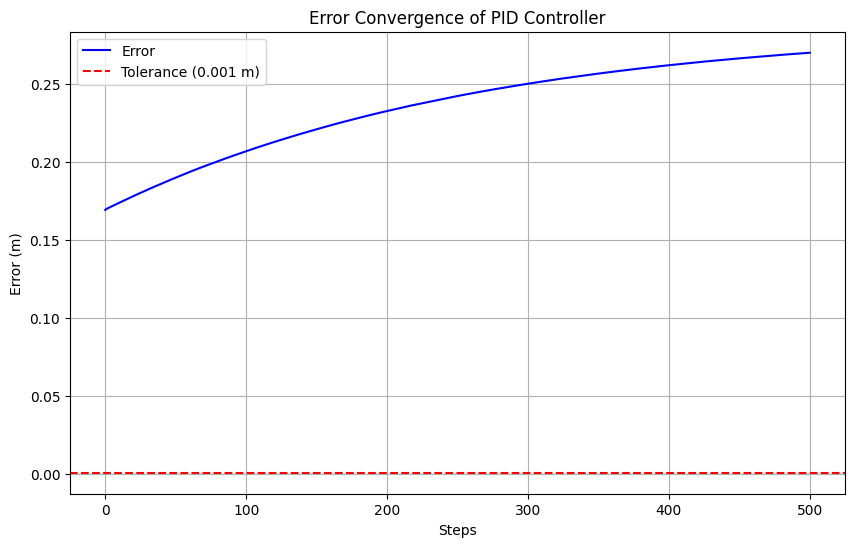

In [1]:
import numpy as np
from ot2_gym_wrapper import OT2Env
import matplotlib.pyplot as plt
from PID import PID
import time

def test_pid_controller():
    # Initialize the OT-2 environment
    env = OT2Env(render=True, max_steps=1000)
    env.reset(seed=42)

    # PID Controllers for each axis
    pid_x = PID(kp=1.0, ki=0.01, kd=0.1, output_limits=(-1, 1))  # X-axis PID
    pid_y = PID(kp=1.0, ki=0.01, kd=0.1, output_limits=(-1, 1))  # Y-axis PID
    pid_z = PID(kp=0.5, ki=0.005, kd=0.05, output_limits=(-1, 1))  # Z-axis PID

    # Target position (meters)
    target_position = np.array([0.2, 0.2, 0.1])

    # Tolerance for error
    tolerance = 0.001  # 1 mm

    # Initialize error tracking
    errors = []
    positions = []

    # Initialize simulation
    obs = env.reset()
    pipette_position = obs[:3]  # Extract initial pipette position
    step_count = 0

    # Start time
    previous_time = time.time()

    while True:
        # Compute errors
        current_time = time.time()
        dt = current_time - previous_time
        previous_time = current_time

        # Ensure dt is always positive and non-zero
        if dt <= 0.0:
            dt = 1e-6  # Set a small positive value for dt

        error = target_position - pipette_position
        total_error = np.linalg.norm(error)
        errors.append(total_error)
        positions.append(pipette_position)

        print(f"Step: {step_count}, Error: {total_error:.6f}, Position: {pipette_position}")

        # Break if error is within tolerance or max steps reached
        if total_error < tolerance or step_count >= 500:
            break

        # PID outputs for each axis
        action_x = pid_x.compute(pipette_position[0], dt)
        action_y = pid_y.compute(pipette_position[1], dt)
        action_z = pid_z.compute(pipette_position[2], dt)

        # Combine actions into a single array
        action = np.array([action_x, action_y, action_z])

        # Apply action to the environment and update state
        obs, _, _, _, _ = env.step(action)
        pipette_position = obs[:3]

        # Increment step count
        step_count += 1

    # Final position and error
    print("\nFinal Results:")
    print(f"Final Position: {pipette_position}")
    print(f"Final Error: {total_error:.6f}")

    # Plot error convergence
    plt.figure(figsize=(10, 6))
    plt.plot(errors, label="Error", color="blue")
    plt.axhline(y=tolerance, color="red", linestyle="--", label=f"Tolerance ({tolerance} m)")
    plt.xlabel("Steps")
    plt.ylabel("Error (m)")
    plt.title("Error Convergence of PID Controller")
    plt.legend()
    plt.grid()
    plt.show()


# Run the test
test_pid_controller()